# Imports and Setup

In [1]:
%cd ..

/Users/jason/repos/diffusion-motion-inbetweening


In [2]:
import warnings
from pathlib import Path

import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from scipy.spatial.transform.rotation import Rotation as R

warnings.filterwarnings("once")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
from data_loaders.humanml.common import quaternion
from data_loaders.humanml.common.skeleton import Skeleton
from data_loaders.humanml.scripts.motion_process import recover_root_rot_pos
from data_loaders.humanml.utils import paramUtil
from utils import rotation_conversions

/Users/jason/repos/diffusion-motion-inbetweening/data_loaders/humanml/common/quaternion.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _FLOAT_EPS = np.finfo(np.float).eps


## Plotting

In [4]:
# @ipywidgets.interact(frame=(0, 195))
def plot_motion(
    samples_glb: np.ndarray,
    groundtruth_glb: np.ndarray,
    name: str,
    frame: int,
    show_ids=False,
    fixed_frames=[],
):
    fig = plt.figure(figsize=(9, 9))
    plt.suptitle(name)

    ax = fig.add_subplot(111, projection="3d")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")

    ax.view_init(elev=10, azim=25, vertical_axis="y")
    ax.axis("equal")

    ax.set_ylim(0, 2)
    ax.set_xlim(-1, 1)
    ax.set_zlim(-1, 1)

    for i in range(samples_glb.shape[0]):
        for chain in paramUtil.t2m_kinematic_chain:
            ax.plot3D(
                samples_glb[i, frame, chain, 0],
                samples_glb[i, frame, chain, 1],
                samples_glb[i, frame, chain, 2],
                color="red",
                alpha=0.5,
            )

    for chain in paramUtil.t2m_kinematic_chain:
        ax.plot3D(
            groundtruth_glb[frame, chain, 0],
            groundtruth_glb[frame, chain, 1],
            groundtruth_glb[frame, chain, 2],
            color="green",
            alpha=1 if frame in fixed_frames else 0.5,
        )

    if show_ids:
        for joint_id in range(groundtruth_glb.shape[1]):
            ax.text(
                groundtruth_glb[frame, joint_id, 0],
                groundtruth_glb[frame, joint_id, 1],
                groundtruth_glb[frame, joint_id, 2],
                f"{joint_id}",
                color="black",
                fontsize=8,
                alpha=0.5,
            )

    plt.show()

In [5]:
def plot_interactive(
    samples_glb: np.ndarray,
    groundtruth_glb: np.ndarray,
    name: str,
    show_ids=False,
    fixed_frames=[],
):
    @ipywidgets.interact(frame=(0, samples_glb.shape[1] - 1))
    def plot(frame):
        plot_motion(samples_glb, groundtruth_glb, name, frame, show_ids, fixed_frames)

    return plot

In [6]:
def plot_mask(name, feat_mask):
    plt.figure(figsize=(8, 6))
    plt.suptitle(name)
    sns.heatmap(feat_mask[:, 0, :], cmap="viridis", cbar=False)
    plt.xlabel("Frames")
    plt.ylabel("Joints")
    plt.tight_layout()
    plt.show()

# Restoring the animation from the rotation vector

1. **Input** the full HML3D feature vector `(n_rep, n_samples, n_frames, 263)`

2. **Extract** root position and joint quaternions from the feature vector `(n_rep, n_samples, n_frames, n_joints, 4)`

3. Apply **Forward Kinematics** to get the joint positions and plot

4. **Export** as BVH

## 1. Input Data

First we load the example skeleton to get the offset values for the joints
with which the dataset has been set up.

In [7]:
face_joint_indx = [2, 1, 17, 16]

example_data = np.load("dataset/000021.npy")
example_data = example_data.reshape(len(example_data), -1, 3)
example_data = torch.from_numpy(example_data)

tgt_skel = Skeleton(
    torch.from_numpy(paramUtil.t2m_raw_offsets), paramUtil.t2m_kinematic_chain, "cpu"
)
tgt_offsets = tgt_skel.get_offsets_joints(example_data[0])

In [8]:
tgt_offsets, tgt_offsets.shape

(tensor([[ 0.0000,  0.0000,  0.0000],
         [ 0.1031,  0.0000,  0.0000],
         [-0.1099,  0.0000,  0.0000],
         [ 0.0000,  0.1316,  0.0000],
         [ 0.0000, -0.3936,  0.0000],
         [ 0.0000, -0.3901,  0.0000],
         [ 0.0000,  0.1432,  0.0000],
         [ 0.0000, -0.4322,  0.0000],
         [ 0.0000, -0.4257,  0.0000],
         [ 0.0000,  0.0574,  0.0000],
         [ 0.0000,  0.0000,  0.1434],
         [ 0.0000,  0.0000,  0.1495],
         [ 0.0000,  0.2193,  0.0000],
         [ 0.1375,  0.0000,  0.0000],
         [-0.1434,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.1031],
         [ 0.0000, -0.1316,  0.0000],
         [ 0.0000, -0.1230,  0.0000],
         [ 0.0000, -0.2569,  0.0000],
         [ 0.0000, -0.2631,  0.0000],
         [ 0.0000, -0.2660,  0.0000],
         [ 0.0000, -0.2697,  0.0000]]),
 torch.Size([22, 3]))

In [9]:
results_path = Path(
    "save/results/condmdi_random_joints/condsamples000750000__benchmark_sparse_T=20_CI=0_CRG=0_KGP=1.0_seed10/results.npy"
    # "save/results/condmdi_random_joints/condsamples000750000__imputation_benchmark_clip_T=40_CI=0_CRG=0_KGP=1.0_seed10_person_throwing_a_ball/results.npy"

)
results = np.load(results_path, allow_pickle=True).item()

In [10]:
for k, v in results.items():
    print(k, v.shape if hasattr(v, "shape") else v)


sample (1, 10, 1, 196, 263)
motion (1, 10, 22, 3, 196)
text (10,)
lengths (1, 10)
num_samples 10
num_repetitions 1
observed_motion (10, 22, 3, 196)
observed_mask (10, 22, 1, 196)


In [11]:
rep_id = 0
sample_id = 2

# Frames where the root bone is observed/fixed
fixed_frames = np.argwhere(results["observed_mask"][sample_id, 0, 0, :] == 1).flatten()
fixed_frames

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180])

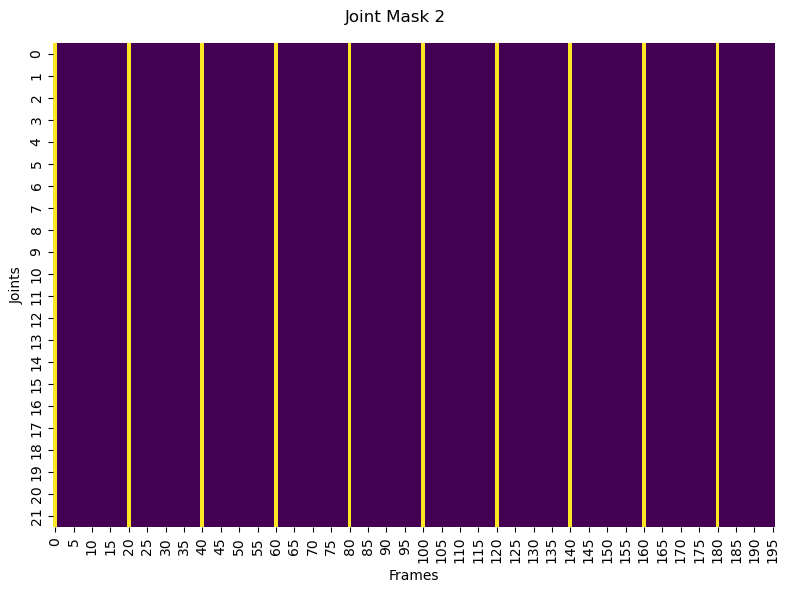

In [12]:
plot_mask(f"Joint Mask {sample_id}", results["observed_mask"][sample_id])


### Testing the `quaternion` module

In [13]:
for i in range(2):
    if i == 0:
        rot = R.from_matrix(torch.eye(3))
    else:
        rot = R.random()
    print("Matrix:")
    print(rot.as_matrix())
    print("")


    print("Matrix as Quat (scalar-first):")
    rotquat = rot.as_quat()[[3, 0, 1, 2]]
    print(rotquat)
    print("")

    print("Quat as Matrix:")
    print(quaternion.quaternion_to_matrix(torch.Tensor(rotquat)))
    print("")

    print("Quat as Cont6D:")
    # rot6d = rotation_conversions.matrix_to_rotation_6d(torch.Tensor(rot.as_matrix()))
    rotquat6d = quaternion.quaternion_to_cont6d(torch.Tensor(rotquat))
    # print(rot6d)
    print(rotquat6d)
    # print(torch.allclose(rot6d, rotquat6d, atol=1e-5))
    print("")

    print("Cont6D as Matrix:")
    rot6d_mat = quaternion.cont6d_to_matrix(rotquat6d)
    print(rot6d_mat)

    # Roundtrip using `quaternion.*`
    assert torch.allclose(rot6d_mat, torch.Tensor(rot.as_matrix()), atol=1e-5)

    print("\n----------------------------------------------------------------\n")


Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Matrix as Quat (scalar-first):
[1. 0. 0. 0.]

Quat as Matrix:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

Quat as Cont6D:
tensor([1., 0., 0., 0., 1., 0.])

Cont6D as Matrix:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

----------------------------------------------------------------

Matrix:
[[ 0.67383375 -0.00367148  0.73887387]
 [ 0.66555373  0.43733485 -0.60479456]
 [-0.3209148   0.89929125  0.29713455]]

Matrix as Quat (scalar-first):
[0.77593543 0.48460405 0.34145518 0.21561885]

Quat as Matrix:
tensor([[ 0.6738, -0.0037,  0.7389],
        [ 0.6656,  0.4373, -0.6048],
        [-0.3209,  0.8993,  0.2971]])

Quat as Cont6D:
tensor([ 0.6738,  0.6656, -0.3209, -0.0037,  0.4373,  0.8993])

Cont6D as Matrix:
tensor([[ 0.6738, -0.0037,  0.7389],
        [ 0.6656,  0.4373, -0.6048],
        [-0.3209,  0.8993,  0.2971]])

----------------------------------------------------------------



## Extract & IK from the original faulty rotation representation

In [54]:
def recover_pos_from_rot(
    data: torch.Tensor, joints_num: int, skeleton: Skeleton, abs_3d=False
):
    # Get root rotation and position
    r_rot_quat, r_pos = recover_root_rot_pos(data, abs_3d=abs_3d)
    r_rot_cont6d = quaternion.quaternion_to_cont6d(r_rot_quat)

    # Extract rotations from feature vector
    start_indx = 1 + 2 + 1 + (joints_num - 1) * 3
    end_indx = start_indx + (joints_num - 1) * 6
    cont6d_params = data[..., start_indx:end_indx]

    # Combine root and joint rotations
    cont6d_params = torch.cat([r_rot_cont6d, cont6d_params], dim=-1)
    cont6d_params = cont6d_params.view(-1, joints_num, 6)

    rotations = quaternion.cont6d_to_matrix(cont6d_params)
    rotations = skeleton.convert_to_standard_convention_rotation(rotations)
    # cont6d_params = quaternion.matrix_to_cont6d(rotations)

    # Forward kinematics to get joint positions
    global_pos, global_rot = skeleton.forward_kinematics_cont6d_standard(cont6d_params, r_pos)
    # global_pos = skeleton.forward_kinematics_cont6d(cont6d_params, r_pos)

    return global_pos, rotations

pos_from_rot, rot = recover_pos_from_rot(
    torch.from_numpy(results["sample"][rep_id, sample_id]),
    joints_num=22,
    skeleton=tgt_skel,
    abs_3d=True,
)
print(pos_from_rot.shape, rot.shape)

torch.Size([196, 22, 3, 1]) torch.Size([196, 22, 3, 3])


In [55]:
plot_interactive(
    samples_glb=pos_from_rot.numpy()[None, ...],
    groundtruth_glb=results["observed_motion"][sample_id].transpose(2, 0, 1),
    name="Pos Recovered from Rot",
    show_ids=False,
    fixed_frames=fixed_frames,
)

interactive(children=(IntSlider(value=97, description='frame', max=195), Output()), _dom_classes=('widget-inte…

<function __main__.plot_interactive.<locals>.plot(frame)>

In [38]:

def recover_rot_from_pos(
    data: torch.Tensor, joints_num: int, skeleton: Skeleton, abs_3d=False, as_quat=False
):
    # Get root rotation and position
    r_rot_quat, r_pos = recover_root_rot_pos(data, abs_3d=abs_3d)

    # Extract joint positions from feature vector
    start_indx = 1 + 2 + 1
    end_indx = start_indx + (joints_num - 1) * 3
    positions = data[..., start_indx:end_indx]
    positions = positions.view(positions.shape[:-1] + (-1, 3))

    """Add Y-axis rotation to local joints"""
    positions = quaternion.qrot(
        quaternion.qinv(r_rot_quat[..., None, :]).expand(positions.shape[:-1] + (4,)),
        positions,
    )

    """Add root XZ to joints"""
    positions[..., 0] += r_pos[..., 0:1]
    positions[..., 2] += r_pos[..., 2:3]

    """Concate root and joints"""
    positions = torch.cat([r_pos.unsqueeze(-2), positions], dim=-2)[0]

    quat_wxyz = skeleton.inverse_kinematics_quat_standard_np(
        positions.numpy(), face_joint_indx
    )

    quat_wxyz = torch.from_numpy(quat_wxyz).float()
    rotations = quaternion.quaternion_to_matrix(quat_wxyz)

    return positions, rotations, quat_wxyz

In [39]:
pos, rot_from_pos, quat_from_pos = recover_rot_from_pos(
    torch.from_numpy(results["sample"][rep_id, sample_id]),
    joints_num=22,
    skeleton=tgt_skel,
    abs_3d=True,
)
print(pos.shape, rot_from_pos.shape, quat_from_pos.shape)

torch.Size([196, 22, 3]) torch.Size([196, 22, 3, 3]) torch.Size([196, 22, 4])


In [40]:
plot_interactive(
    pos.numpy()[None, ...],
    results["observed_motion"][sample_id].transpose(2, 0, 1),
    "Recovered Pos",
    show_ids=False,
    fixed_frames=fixed_frames,
)

interactive(children=(IntSlider(value=97, description='frame', max=195), Output()), _dom_classes=('widget-inte…

<function __main__.plot_interactive.<locals>.plot(frame)>

---
---
---

In [41]:
from convert.joints2bvh import BVH, Animation
from convert.joints2bvh.Quaternions import Quaternions


In [42]:
anim = BVH.load("convert/joints2bvh/data/template.bvh")
anim.rotations.qs.shape

(720, 22, 4)